# Factorization Machine을 활용한 광고 CTR 예측 알고리즘
- 광고 추천에는 user와 ad 사이의 interaction을 고려하는 것이 중요하다.
- classification의 가장 대표적인 logit regression의 경우 linear한 영향만 고려하기 때문에 interaction을 고려하지 못한다.
- Factorization Mahine(FM)은 광고 추천에 활용하면 user와 ad사이의 interaction을 고려한 알고리즘을 구축할 수 있다.
- 또한, FM은 sparse data를 다루는데 특화가 되어있기 때문에 highly sparse data인 click-through data에 적합한 머신이라고 할 수 있다.
- 이에 FM을 활용하여서 Click-Through Rate(CTR) 예측 알고리즘을 구축해보겠다.
    - FM의 장점을 활용할 수 있는 새로운 CTR 계산법인 historical and predicted CTR (hpCTR)을 소개하겠다.
- 더 나아가, CTR 데이터의 class는 positive class인 click(+1)과 negative class인 unclick(-1)로 구성되어있다. pisitive class는 전체 샘플 중  1~10%밖에 차지하지 않아서 클래스 불균형 문제가 존재한다. 따라서 본 노트에서는 클래스 불균형 문제가 있는 CTR 데이터에 대해서 재샘플링과 비용민감모델을 활용하여 클래스 불균형 문제를 해결해보겠다.
- 본 실험은 'fastFM' library를 활용했다


## 목차
1. [데이터 생성 및 탐색](#1.-데이터-생성-및-탐색)
1. [only Factorizaton Machines](#2.-only-Factorizaton-Machines)
1. [비용민감모델+Factorizaton Machines](#3.-비용민감모델+Factorizaton-Machines)
1. [재샘플링 : SMOTE, Borderline-SMOTE](#4.-재샘플링-:-SMOTE,-Borderline\-SMOTE)
1. [클래스 불균형 문제에대한 실험 결과](#5.-클래스-불균형-문제에대한-실험-결과)
1. [hpCTR과 eCPM 예측 예시](#6.-hpCTR과-eCPM-예측-예시)



In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import minmax_scale

## 1. 데이터 생성 및 탐색
- 데이터로는 fastFM에서 제공하는 FM 테스트 용 랜덤 데이터에 클래스 불균형을 준 데이터를 사용할 것이다.
- 파이프라인 (자세한 설명은 발표자료 참고):  
    1. 광고(ex) a)가 들어오면 그 광고는 clustering algorithm에의해서 이미 구축되어있는 A, B, C, .. clusters 중 적절한 cluster로 배정된다(ex) A). 
         - FM의 사이즈를 줄여서 머신 속도를 올리기위함. 실제 카카오에서는 clustering을 통한 차원 축소를 한다. [ref. Kakao AI report vol.05]
    1. A cluster로 배정된 광고 a는 '클러스터의 모든 유저+광고a'를 concatenate하여 A cluster의 FM에 태운다.
    1. A의 FM은 모든 유저에게 한번씩 노출되었을 시 광고 a가 클릭될 비율인 hpCTR을 예측하여 출력한다.

### 데이터 수집(생성)
- 데이터 수집단계 대신 fastFM에서 제공하는 데이터 생성 알고리즘을 통해서 데이터를 생성하고 raw 데이터 형태로 변경해서 시작하겠다.

In [2]:
from fastFM.datasets import make_user_item_regression

num_of_users = 100 # 생성할 데이터의 user 수
num_of_items = 100 # 생성할 데이터의 item 수 (광고들)
for_imbalance = 223 #클래스 불균형을 만들기위한 수치. cf) 불균형 X: y.mean()

# This sets up a small test dataset.
X, y, _ = make_user_item_regression(n_user=num_of_users, n_item=num_of_items)

# Convert dataset to binary classification task.
y_labels = np.ones_like(y)
y_labels[y < for_imbalance] = -1 

# convert the data into the form of the raw data.
X_ar = X.toarray()
X_raw = [{'user': '{}'.format(X_ar[i][:100].argmax()), \
                      'AD': '{}'.format(X_ar[i][100:].argmax())} \
                      for i in range(len(X_ar))]
print('The data has the below form.\n', '>>',\
      X_raw[:20])


The data has the below form.
 >> [{'user': '0', 'AD': '0'}, {'user': '0', 'AD': '1'}, {'user': '0', 'AD': '2'}, {'user': '0', 'AD': '3'}, {'user': '0', 'AD': '4'}, {'user': '0', 'AD': '5'}, {'user': '0', 'AD': '6'}, {'user': '0', 'AD': '7'}, {'user': '0', 'AD': '8'}, {'user': '0', 'AD': '9'}, {'user': '0', 'AD': '10'}, {'user': '0', 'AD': '11'}, {'user': '0', 'AD': '12'}, {'user': '0', 'AD': '13'}, {'user': '0', 'AD': '14'}, {'user': '0', 'AD': '15'}, {'user': '0', 'AD': '16'}, {'user': '0', 'AD': '17'}, {'user': '0', 'AD': '18'}, {'user': '0', 'AD': '19'}]


### 데이터 전처리 및 탐색
- 수집된 로우 데이터 sklearn의 DictVectorizer을 활용하여서 벡터로 만들어주겠다.
- 특징과 클래스, sparsity, imbalance 등을 탐색하는 데이터 탐색을 진행하겠다.

In [3]:
# {'user': '95', 'AD': '0'} -> [0,0,..,1,0,0,..,0,0,..,1,0,...]
v = DictVectorizer()
X_vec = v.fit_transform(X_raw)
print(X_vec[:5])

  (0, 0)	1.0
  (0, 100)	1.0
  (1, 1)	1.0
  (1, 100)	1.0
  (2, 12)	1.0
  (2, 100)	1.0
  (3, 23)	1.0
  (3, 100)	1.0
  (4, 34)	1.0
  (4, 100)	1.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_labels, random_state=77)
#print(X_train.toarray())

In [5]:
# X_train and y_train in DataFrame
col = ['user{}'.format(i) for i in range(num_of_users)] \
+ ['AD{}'.format(i) for i in range(num_of_items)]
x_df = pd.DataFrame(X_train.toarray(), columns=col)
y_df = pd.Series(y_train,name='click')
df = pd.concat([y_df, x_df],axis=1)
print(df.shape)
print('cf) click: "+1=click, -1=unclick"')
df.head()

(7500, 201)
cf) click: "+1=click, -1=unclick"


,click,user0,user1,user2,user3,user4,user5,user6,user7,user8,...,AD90,AD91,AD92,AD93,AD94,AD95,AD96,AD97,AD98,AD99
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# 전체 광고와 전체 유저를 대상으로한 raio = number_of_+1/total_number_of_y 
print('[train] ratio = ', round(100*(y_train==1).sum()/len(y_train),2),'%') 
# number of positive and negative class
print('[train]','number of positive class(+1) = ', (y_train==1).sum(),', ','number of negative class(-1) = ', len(y_train)-(y_train==1).sum())
# sparsity
print('[train] sparsity: ',100*X_train.toarray().sum()/(7500*200), '%')

[train] ratio =  7.17 %
[train] number of positive class(+1) =  538 ,  number of negative class(-1) =  6962
[train] sparsity:  1.0 %


**데이터 탐색 결과**
- Features :
    - 전체 x값들 중 1.0%만 값을 가지고 나머지는 전부 0이다. 데이터가 highly sparse하다.
    - 특징들은 크게 user와 AD(광고) 그룹으로 이루어져있다. CTR 예측에서는 둘 사이의 interaction을 고려해야한다.
    - 따라서, sparse한 데이터셋에서 interaction을 고려하기 용이한 FM을 사용하겠다.
- class : 
    - 전체 y값들 중 약 7~8%만 positive class(+1)이고 나머지는 negative class(-1)이다. 
    - 클래스 불균형이 심하다.
    - 비용민감모델/재샘플링을 적용하여 클래스 불균형 문제를 해결하겠다.
    

## 2. only Factorizaton Machines
- 뒤에 나올 비용민감모델과 재샘플링 실험에 대한 대조군을 위해서 데이터에 대한 처리나 모델의 수정 없이 FM을 돌려서 click-through 데이터를 훈련시키고, test set에 대한 예측을 진행해보겠다.

In [7]:
from fastFM import sgd

# check time
start_time = time.time()

fastFM = sgd.FMClassification(n_iter=100000, init_stdev=0.1, l2_reg_w=0,\
                          l2_reg_V=0, rank=2, step_size=0.1)
fastFM.fit(X_train, y_train)

preds_fm = fastFM.predict(X_test)

print('--------------------')
print('Accuracy:', round(accuracy_score(y_test, preds_fm),3))
print('Precision: ', round(precision_score(y_test, preds_fm),3))
print('Recall: ', round(recall_score(y_test, preds_fm),3))
print('F1-score: ', round(f1_score(y_test, preds_fm),3))
print('Ratio: ', 100*(preds_fm==1).sum()/len(preds_fm),'%')
# check time
print("--- %s seconds ---" % round((time.time() - start_time),5))

--------------------
Accuracy: 0.987
Precision:  0.958
Recall:  0.864
F1-score:  0.909
Ratio:  6.64 %
--- 0.02412 seconds ---


In [8]:
print('cf) [test set] true ratio: ', 100*(y_test==1).sum()/len(y_test),'%')

cf) [test set] true ratio:  7.36 %


**결과**
- 데이터 자체가 FM를 테스트하기 위해 만들어진 데이터이다 보니 accuracy 자체가 상당히 잘 나오고, 클래스 불균형을 해결하지 않아도 F1-score가 높게 나왔다.
- 하지만 그래도 불균형된 데이터이다 보니 accuracy나 precision에 비해서 recall과 F1-score가 낮게 나옴을 확인할 수 있다.
- 그리고 test set의 true ratio에 비해서 positve class의 비율인 predicted ratio가 낮은 것을 확인할 수 있다. 
    - test set true ratio : 7.36%, predicted ratio: 6.8%
- 클래스 불균형 문제에서 발생하는 전형적인 현상이다.
- 데이터의 클래스불균형 문제를 해결하여 F1-score을 높이고 ratio를 true 값에 가깝게 예측되도록 해보겠다.

## 3. 비용민감모델+Factorizaton Machines
- click을 unclick으로 예측하게 되면 CTR자체가 실제보다 낮게 계산되게 된다. CTR은 광고료 책정에 직결되기 때문에 광고 플랫폼(카카오)입장에서는 굉장히 큰 비용 손실이라고 할 수 있다. 따라서 본 섹션에서는 이에 대한 개선을 위해서 비용민감모델(Cost Sensitive Model : CSM)을 도입해보겠다.
- 전략
    - fastFM 라이브러리에서는 classification에 대한 출력값을 binary 형태가 아닌 continous value로 출력해주는 기능이 있다.
    - train 데이터를 대상으로 예측값을 continous value로 얻어내고, classification의 기준인 threshold을 조정하여 가장 높은 F1-score을 주는 threshold를 선택한다.
    - 선택된 threshold로 FM을 비용민감모델로 만든다. 

### 비용민감모델 구축
- 앞서 훈련된 모델을 활용한다.
- 먼저 train set에 대한 F1-score을 maximize하는 threshold를 얻어보겠다.

In [9]:
# continous value로 예측값 얻기
pred_prob = fastFM.predict_proba(X_train) # 일단 train으로 threshold 조정 후 test에 도입
pred_prob = minmax_scale(pred_prob)
#scaler = MinMaxScaler() : 객체화해서 일관되게 써야함.


In [10]:
# Grid search with respect to threshold
alpha_ls = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7] # threshold 후보들
acc_ls, prec_ls, recall_ls, f1_ls, ratio_ls = [], [], [], [], []
Nround=6

for alpha in alpha_ls:

    pred_proba = pred_prob.copy()
    
    #classification
    pred_proba[pred_proba < alpha] = -1
    pred_proba[pred_proba >= alpha] = 1
    
    acc_ls+=[round(accuracy_score(y_train, pred_proba),Nround)]
    prec_ls+=[round(precision_score(y_train, pred_proba),Nround)]
    recall_ls+=[round(recall_score(y_train, pred_proba),Nround)]
    f1_ls+=[round(f1_score(y_train, pred_proba),Nround)]
    ratio_ls+=[round(100*(pred_proba==1).sum()/len(pred_proba),Nround)]

In [11]:
# Grid search 결과 데이터프레임화
data = {'Threshold': alpha_ls, 'Accuracy':acc_ls, 'Precision':prec_ls, \
        'Recall':recall_ls, 'F1-score':f1_ls, 'Ratio':ratio_ls}
df_data = pd.DataFrame(data)
df_data

,Threshold,Accuracy,Precision,Recall,F1-score,Ratio
0,0.20,0.994267,0.931937,0.992565,0.961296,7.640000
1,0.25,0.995867,0.955117,0.988848,0.971689,7.426667
2,0.30,0.996133,0.968692,0.977695,0.973173,7.240000
3,0.35,0.996667,0.981238,0.972119,0.976657,7.106667
4,0.40,0.996667,0.988571,0.964684,0.976482,7.000000
5,0.45,0.995733,0.990310,0.949814,0.969639,6.880000
6,0.50,0.995200,0.992157,0.940520,0.965649,6.800000
7,0.55,0.994533,0.997996,0.925651,0.960463,6.653333
8,0.60,0.993867,0.997976,0.916357,0.955426,6.586667
9,0.65,0.992533,0.997934,0.897770,0.945205,6.453333


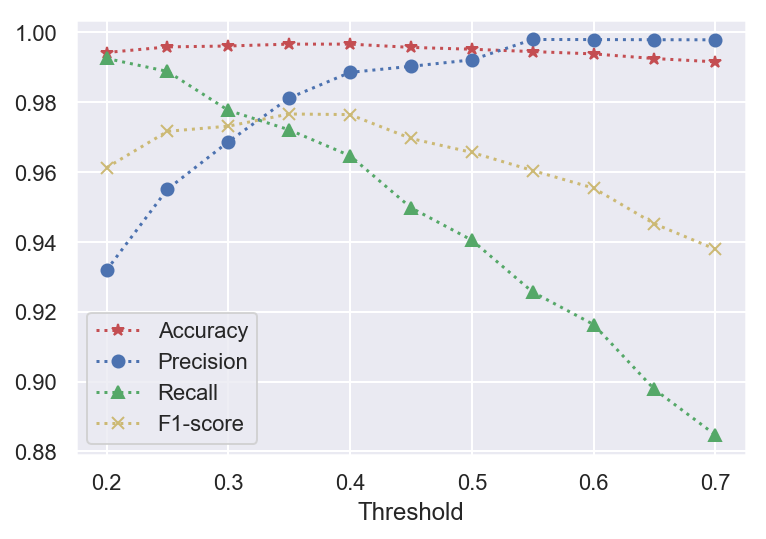

In [12]:
# Grid search 결과 그래프화
plt.plot(alpha_ls, acc_ls,'r*:', label='Accuracy') 
plt.plot(alpha_ls, prec_ls, 'bo:', label='Precision')
plt.plot(alpha_ls, recall_ls, 'g^:', label='Recall')
plt.plot(alpha_ls, f1_ls, 'yx:', label='F1-score')
plt.legend(loc=0)
plt.xlabel('Threshold')
plt.show()

In [13]:
# F1-score을 최대화하는 threshold 선택.
threshold = df_data[df_data['F1-score'] == max(df_data['F1-score'])]['Threshold'].iloc[0]
df_data[df_data['F1-score'] == max(df_data['F1-score'])]

,Threshold,Accuracy,Precision,Recall,F1-score,Ratio
3,0.35,0.996667,0.981238,0.972119,0.976657,7.106667


**Threshold에 대한 Grid search 결과**
- Threshold를 작게 만들어서 모델을 민감하게 만들 수록 recall은 커지는 반면에 precision은 작아진다.
    즉, negative class에 대한 정확도를 희생해서 positve class의 정확도를 올린다고 해석할 수 있다.
- 적정 Threshold를 정함에 있어서 precision을 얼마나 희생하고 recall을 올릴 것인가의 문제가 있다.
- 이 때문에 클래스 불균형 문제에서는 기준 메트릭으로 F1-score(= precistion과 recall의 조화평균)을 사용한다.
- 이 모델에서는 F1-score가 threshold=0.35일 때 가장 최대치가 된다.
- 따라서 threshold=0.35으로 설정하여 FM을 비용민감모델로 만든다면 positive class에대한 오분류를 줄일 수 있다.

### Predcition

In [14]:
pred_proba_test = fastFM.predict_proba(X_test)
pred_proba_test = minmax_scale(pred_proba_test)
pred_proba_test[pred_proba_test < threshold] = -1
pred_proba_test[pred_proba_test >= threshold] = 1
    
print('--------------------')
print('Accuracy:', round(accuracy_score(y_test, pred_proba_test),Nround))
print('Precision: ', round(precision_score(y_test, pred_proba_test),Nround))
print('Recall: ', round(recall_score(y_test, pred_proba_test),Nround))
print('F1-score: ', round(f1_score(y_test, pred_proba_test),Nround))
print('Ratio: ', round(100*(pred_proba_test==1).sum()/len(pred_proba_test),Nround),'%')
print('--------------------')

--------------------
Accuracy: 0.9876
Precision:  0.937143
Recall:  0.891304
F1-score:  0.913649
Ratio:  7.0 %
--------------------


**비용민감모델 적용 결과**
- 대조군(only FM)의 결과와 비교했을 때 F1-score값이 상승한 것을 볼 수 있다. 그리고 클래스의 ratio가 정답셋의 true ratio에 더 가까워졌음을 확인할 수 있다.
- cf) [test set] true ratio:  7.36 %
- cf) only FM
    - Accuracy: 0.987 
    - Precision:  0.958
    - Recall:  0.864
    - F1-score:  0.909
    - Ratio:  6.64 %

## 4. 재샘플링 : SMOTE, Borderline-SMOTE
- 훈련 데이터(7500개)에 소수 클래스가 538개로 절대 부족이기 때문에 **오버샘플링을 진행**하겠다.
    - cf) 실제 데이터에서는 데이터양이 매우 크기 때문에 절대 부족이 발생하진 않을 것이다. 따라서 실제 데이터에대해서는 언더샘플링을 고려해볼 수도 있을 것이다.
- 많이 쓰이는 오버샘플링에는 SMOTE와 Borderline-SMOTE가 있다.
    - SMOTE : 소수클래스 샘플의 이웃을 k개 선택하여 그 중간에 샘플을 생성한다. 소수클래스와 다수클래스이 경계는 그대로이다.
    - Borderline-SMOTE : 다수 클래스 샘플과 가까운 소수클래스 샘플의 이웃을 k개 선택하여 그 중간에 샘플을 생성한다. 소수클래스와 다수클래스의 경계를 밀어주는 효과가 생긴다.    

In [15]:
# 절대 부족, 상대 부족 확인
print('positve_class: ',100*(y_train==1).sum(), ', ','total: ',len(y_train))
print('positve_class/total: ', round(100*(y_train==1).sum()/len(y_train),2), '%')


positve_class:  53800 ,  total:  7500
positve_class/total:  7.17 %


### SMOTE : oversampling

In [16]:
import imblearn.over_sampling as osam

In [17]:
#SMOTE : knn 원리로 소수클래스 재샘플링(소수클래스 결정공간은 그대로.)
SMOTEos = osam.SMOTE(k_neighbors=5)
osm_X1, osm_Y1 = SMOTEos.fit_sample(X_train, y_train)

In [18]:
print('positve_class/total: ', round(100*(osm_Y1==1).sum()/len(osm_Y1),2), '%')

positve_class/total:  50.0 %


In [19]:
fastFM_SMOTE = sgd.FMClassification(n_iter=100000, init_stdev=0.1, l2_reg_w=0,\
                          l2_reg_V=0, rank=2, step_size=0.1)
fastFM_SMOTE.fit(osm_X1, osm_Y1)

preds_fm_SMOTE = fastFM_SMOTE.predict(X_test)

print('--------------------')
print('Accuracy:', round(accuracy_score(y_test, preds_fm_SMOTE),3))
print('Precision: ', round(precision_score(y_test, preds_fm_SMOTE),3))
print('Recall: ', round(recall_score(y_test, preds_fm_SMOTE),3))
print('F1-score: ', round(f1_score(y_test, preds_fm_SMOTE),3))
print('Ratio: ', 100*(preds_fm_SMOTE==1).sum()/len(preds_fm_SMOTE),'%')
print('--------------------')

--------------------
Accuracy: 0.981
Precision:  0.966
Recall:  0.772
F1-score:  0.858
Ratio:  5.88 %
--------------------


### Borderline-SMOTE : oversampling

In [20]:
#Borderline-SMOTE : knn 원리로 소수클래스의 결정공간을 확장 시켜줌.
B_SMOTEos = osam.SMOTE(k_neighbors=5, m_neighbors=5)
osm_X2, osm_Y2 = B_SMOTEos.fit_sample(X_train, y_train)

In [21]:
print('positve_class/total: ', round(100*(osm_Y2==1).sum()/len(osm_Y2),2), '%')


positve_class/total:  50.0 %


In [22]:
fastFM_BSMOTE = sgd.FMClassification(n_iter=100000, init_stdev=0.1, l2_reg_w=0,\
                          l2_reg_V=0, rank=2, step_size=0.1)
fastFM_BSMOTE.fit(osm_X2, osm_Y2)

preds_fm_BSMOTE = fastFM_BSMOTE.predict(X_test)

print('--------------------')
print('Accuracy:', round(accuracy_score(y_test, preds_fm_BSMOTE),3))
print('Precision: ', round(precision_score(y_test, preds_fm_BSMOTE),3))
print('Recall: ', round(recall_score(y_test, preds_fm_BSMOTE),3))
print('F1-score: ', round(f1_score(y_test, preds_fm_BSMOTE),3))
print('Ratio: ', 100*(preds_fm_BSMOTE==1).sum()/len(preds_fm_BSMOTE),'%')
print('--------------------')

--------------------
Accuracy: 0.982
Precision:  0.966
Recall:  0.777
F1-score:  0.861
Ratio:  5.92 %
--------------------


## 5. 클래스 불균형 문제에대한 실험 결과 비교

In [23]:
Alist = [round(accuracy_score(y_test, preds_fm),3),\
         round(accuracy_score(y_test, pred_proba_test),3),\
         round(accuracy_score(y_test, preds_fm_SMOTE),3),\
         round(accuracy_score(y_test, preds_fm_BSMOTE),3)]
Plist = [round(precision_score(y_test, preds_fm),3),\
         round(precision_score(y_test, pred_proba_test),3),\
         round(precision_score(y_test, preds_fm_SMOTE),3),\
         round(precision_score(y_test, preds_fm_BSMOTE),3)]
Rlist = [round(recall_score(y_test, preds_fm),3),\
         round(recall_score(y_test, pred_proba_test),3),\
         round(recall_score(y_test, preds_fm_SMOTE),3),\
         round(recall_score(y_test, preds_fm_BSMOTE),3)]
f1list = [round(f1_score(y_test, preds_fm),3),\
          round(f1_score(y_test, pred_proba_test),3),\
          round(f1_score(y_test, preds_fm_SMOTE),3),\
          round(f1_score(y_test, preds_fm_BSMOTE),3)]
Clist = [str(100*(preds_fm==1).sum()/len(preds_fm))+'%',\
         str(round(100*(pred_proba_test==1).sum()/len(pred_proba_test),3))+'%',\
         str(100*(preds_fm_SMOTE==1).sum()/len(preds_fm_SMOTE))+'%',\
         str(100*(preds_fm_BSMOTE==1).sum()/len(preds_fm_BSMOTE))+'%']

comparison = {'': ['FM', 'CSM+FM', 'SMOTE+FM', 'B-SMOTE+FM'],
              'Accuracy': Alist, 
              'Precision': Plist,
              'Recall':  Rlist, 
              'F1-score':  f1list,
              'Ratio':  Clist}

In [24]:
pd.DataFrame(comparison)

,,Accuracy,Precision,Recall,F1-score,Ratio
0,FM,0.987,0.958,0.864,0.909,6.64%
1,CSM+FM,0.988,0.937,0.891,0.914,7.0%
2,SMOTE+FM,0.981,0.966,0.772,0.858,5.88%
3,B-SMOTE+FM,0.982,0.966,0.777,0.861,5.92%


**결론**
- FM을 비용민감모델(CSM)로 만든 파이프라인이 가장 높은 F1-score을 보여준다. Accuracy도 가장 높고, Ratio도 true ratio와 가장 일치한다.
- 의외로 재샘플링은 오히려 Accuracy 뿐만 아니라 F1-score을 떨어트렸다.
    - 이 이유는 데이터 자체가 FM을 테스트하기 위한 것이다 보니 재샘플링을 한 fake data가 들어가는 것 자체로 Accuracy, F1-score에 악영향을 미친것이라고 추측할 수 있다. 실제 데이터에서는 재샘플링이 더 좋은 결과를 줄 가능성이 있다.
- **결론적으로, click-through data에 대해서 FM을 활용할 때는 비용민감모델을 쓰는 것이 클래스 불균형 문제를 가장 잘 해결해준다.**
- 이제 비용민감모델로 만들어진 Factorization machine(FM+CSM)을 적용하여 Click-through rate를 예측해보겠다.

# 6. hpCTR과 eCPM 예측 예시
- **hpCTR이란?** historical and predicted CTR(hpCTR) = 그룹화된 유저에게 특정광고가 한번씩 노출되었을 때 발생할 클릭수/그룹내 총 유저수
    - historical CTR(hCTR)은 과거 데이터로만 총 노출수 대비 클릭 횟수를 계산한다. 쉽게 계산할 수 있다는 장점이 있지만 hCTR 데이터에 없는 내용이 반영되지 않는 문제점이 있다.
    - predicted CTR(pCTR)은 보통 Logistic Regression으로 예측하는 조건부 확률이다. 특정 유저에게 특정 광고가 노출되었을 때 그 유저가 광고를 클릭할 확률로 계산한다. pCTR은 유저 개개인에 대상으로 광고를 클릭할 확률을 구할 수 있다는 장점이 있지만 linear한 효과만 고려하는 Logistic Regression을 사용했다는 점과 데이터가 부족한 신입 유저에 대해서는 정확한 예측이 어렵다는 단점이 있다.
    - 이 노트에서 새롭게 제시한 hpCTR은 사전 클러스터링이 된 그룹의 유저들을 대상으로 특정 광고가 단 한번씩 노출되었을 시의 클릭 비율을 계산한다. 
        - FM을 활용하여 유저들과 광고사이의 historical data로부터 데이터에 없는 모든 interaction을 예측하여 CTR을 계산한다. 
        - FM을 활용하기 때문에 신입유저의 데이터가 적어도 광고들 사이의 interaction을 높은 정확도로 예측할 수 있다. 
        - 그룹의 유저들을 대상으로 특정 광고가 단 한번씩 노출되었을 시의 클릭 비율을 계산하는 것이기때문에 같은 유저에게 중복 노출이 되었을 경우 등의 상황이 자연스럽게 제외된다는 장점이 있다.
- 전략 :
    - CTR을 구할 광고를 하나 선택하고, 모든 유저와 매치시키는 데이터를 생성한다.
        - ex) for AD5, [{User0,AD5}, {User1,AD5}, ...., {user99,AD5}]
    - 앞서 훈련 데이터에 적용했던 DictVectorizor로 vector화한다.
    - 이 데이터를 훈련된 FM+CSM에 태워서 각 유저들에 따른 AD5의 클릭 여부를 예측한다.
    - 이를 바탕으로 모든 유저에게 특정 광고가 노출되었을 때의 hpCTR을 예측할 수 있다.
    - 그것을 바탕으로 eCPM(effective cost per mile = hpCTR x bid x 1000)을 계산한다.

- 예를 들어,
    - 유저들을 사전 클러스터링해서 차원 축소를 해준다.
    - 만약, 클러스터 중 하나를 20대 남성 그룹이라고 가정하자.
    - 이 그룹에 대해서 CTR 계산을 원하는 광고(A)를 이 그룹에서 훈련된 FM에 넣고, 출력값으로 hpCTR을 얻는다.
    - 계산된 hpCTR로 eCPM을 계산한다. 
    - 이제 20대 남성 유저가 접속했을 때 계산된 광고A의 eCPM을  다른 광고들의 eCPM과 비교하여 노출여부를 결정한다. 그리고 노출 후 클릭 액션이 발생시 eCPM을 기준으로 과금액이 상정된다.

In [25]:
# eCPM 계산하는 함수

def eCPM_is(check_AD_str, bid = 2000, n_eCPM = 1000, threshold_ = 0.5):
    '''
    check_AD_str : eCPM을 계산하고 싶은 광고의 숫자를 string으로 입력한다. ex) '5'
    n_eCPM : eCPM이 1000회 노출당 과금액이므로 default는 1000이다.
    bid : 1회 노출당 기준 과금액
    threshold_ : 비용민감모델의 기준 threshold 값 입력.
    '''
     
    check_AD = check_AD_str 
    thres = threshold_
    
    # data
    test_raw = [{'user': '{}'.format(i), 'AD': check_AD}\
             for i in range(num_of_users)]

    # v : used DictVectorizer
    test_vec = v.transform(test_raw)

    # prediction
    test_pred = fastFM.predict_proba(test_vec)
    test_pred = minmax_scale(test_pred)
    
    test_pred[test_pred < thres] = -1
    test_pred[test_pred >= thres] = 1
    
    hpCTR = (test_pred==1).sum()/len(test_pred)
    eCPM = int(hpCTR*bid*n_eCPM)
    
    print('------------------------------------')
    print('AD{}\'s hpCTR w.r.t. the user group: '.format(check_AD),\
          round(100*hpCTR,2),'%')
    print('AD{}\'s eCPM: '.format(check_AD), eCPM, '원')
    print('------------------------------------')


### hpCTR과 eCPM 예측 : Cost Sensitive Model +  Factorizaion Machines

In [26]:
print('------------------------------------')
print('Cost Sensitive Model + Factorization Machines')
eCPM_is(check_AD_str='0', bid = 2000, threshold_=threshold)
eCPM_is(check_AD_str='10', bid = 2000, threshold_=threshold)
eCPM_is(check_AD_str='35', bid = 2000, threshold_=threshold)
eCPM_is(check_AD_str='44', bid = 2000, threshold_=threshold)
print('cf) bid = 2000')

------------------------------------
Cost Sensitive Model + Factorization Machines
------------------------------------
AD0's hpCTR w.r.t. the user group:  1.0 %
AD0's eCPM:  20000 원
------------------------------------
------------------------------------
AD10's hpCTR w.r.t. the user group:  7.0 %
AD10's eCPM:  140000 원
------------------------------------
------------------------------------
AD35's hpCTR w.r.t. the user group:  24.0 %
AD35's eCPM:  480000 원
------------------------------------
------------------------------------
AD44's hpCTR w.r.t. the user group:  23.0 %
AD44's eCPM:  460000 원
------------------------------------
cf) bid = 2000


### hpCTR과 eCPM 예측 : only Factorizaion Machines (대조군)

In [27]:
# 대조군에서 hpCTR과 eCPM
'''
ex) 비용민감모델을 안쓴 경우 : '35', '44'번 광고의 경우 pCTR이 더 낮게 책정되고,
eCPM도 낮게 책정되었음을 볼 수 있다. 
'''
print('------------------------------------')
print('Only Factorization Machines')
eCPM_is(check_AD_str='0', bid = 2000)
eCPM_is(check_AD_str='10', bid = 2000)
eCPM_is(check_AD_str='35', bid = 2000)
eCPM_is(check_AD_str='44', bid = 2000)
print('cf) bid = 2000')

------------------------------------
Only Factorization Machines
------------------------------------
AD0's hpCTR w.r.t. the user group:  1.0 %
AD0's eCPM:  20000 원
------------------------------------
------------------------------------
AD10's hpCTR w.r.t. the user group:  7.0 %
AD10's eCPM:  140000 원
------------------------------------
------------------------------------
AD35's hpCTR w.r.t. the user group:  23.0 %
AD35's eCPM:  460000 원
------------------------------------
------------------------------------
AD44's hpCTR w.r.t. the user group:  22.0 %
AD44's eCPM:  440000 원
------------------------------------
cf) bid = 2000


### 모든 광고의 hpCTR 및 eCPM 예측 : Cost Sensitive Model + Factorization Machines

In [28]:
# 모든 광고의 hpCTR 및 eCPM 계산 for CSM
print('------------------------------------')
print('Cost Sensitive Model + Factorization Machines')
for i in range(num_of_items):
    eCPM_is(check_AD_str='{}'.format(i), bid = 2000, threshold_=threshold)

------------------------------------
Cost Sensitive Model + Factorization Machines
------------------------------------
AD0's hpCTR w.r.t. the user group:  1.0 %
AD0's eCPM:  20000 원
------------------------------------
------------------------------------
AD1's hpCTR w.r.t. the user group:  1.0 %
AD1's eCPM:  20000 원
------------------------------------
------------------------------------
AD2's hpCTR w.r.t. the user group:  24.0 %
AD2's eCPM:  480000 원
------------------------------------
------------------------------------
AD3's hpCTR w.r.t. the user group:  8.0 %
AD3's eCPM:  160000 원
------------------------------------
------------------------------------
AD4's hpCTR w.r.t. the user group:  50.0 %
AD4's eCPM:  1000000 원
------------------------------------
------------------------------------
AD5's hpCTR w.r.t. the user group:  1.0 %
AD5's eCPM:  20000 원
------------------------------------
------------------------------------
AD6's hpCTR w.r.t. the user group:  1.0 %
AD6's eCPM

------------------------------------
AD67's hpCTR w.r.t. the user group:  7.0 %
AD67's eCPM:  140000 원
------------------------------------
------------------------------------
AD68's hpCTR w.r.t. the user group:  9.0 %
AD68's eCPM:  180000 원
------------------------------------
------------------------------------
AD69's hpCTR w.r.t. the user group:  1.0 %
AD69's eCPM:  20000 원
------------------------------------
------------------------------------
AD70's hpCTR w.r.t. the user group:  1.0 %
AD70's eCPM:  20000 원
------------------------------------
------------------------------------
AD71's hpCTR w.r.t. the user group:  39.0 %
AD71's eCPM:  780000 원
------------------------------------
------------------------------------
AD72's hpCTR w.r.t. the user group:  1.0 %
AD72's eCPM:  20000 원
------------------------------------
------------------------------------
AD73's hpCTR w.r.t. the user group:  1.0 %
AD73's eCPM:  20000 원
------------------------------------
-----------------------

# - The End -